In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report

In [2]:
# Ignoring warnings (many warnings come from the FairLearn package)
import warnings
warnings.filterwarnings('ignore')

#### Reading in the data and getting an overview

In [3]:
# Starting with 35k observations that have NA values filled from KNN imputation
df = pd.read_csv('na_filled_df.csv').sample(n=35000, random_state=2025)
print(df.shape)
print(df.columns)

(35000, 21)
Index(['action_taken', 'preapproval', 'property_value', 'loan_purpose',
       'lien_status', 'reverse_mortgage', 'open-end_line_of_credit',
       'business_or_commercial_purpose', 'loan_amount', 'loan_to_value_ratio',
       'loan_term', 'negative_amortization', 'occupancy_type', 'income',
       'debt_to_income_ratio', 'applicant_sex', 'conforming_loan_limit',
       'derived_loan_product_type', 'derived_dwelling_category',
       'derived_race', 'applicant_age_above_62'],
      dtype='object')


****

### Formatting the data

In [4]:
# Finding categorical variables
string_columns = df.select_dtypes(include=['object']).columns
string_df = df[string_columns].copy()
print(string_columns)
sensitive_features = df[['applicant_sex', 'derived_race', 'applicant_age_above_62']].copy()

Index(['applicant_sex', 'conforming_loan_limit', 'derived_loan_product_type',
       'derived_dwelling_category', 'derived_race', 'applicant_age_above_62'],
      dtype='object')


In [5]:
# Making sure these are strings and not mixed data types
df['applicant_sex'] = df['applicant_sex'].astype(str)
df['applicant_age_above_62'] = df['applicant_age_above_62'].astype(str)
df['derived_race'] = df['derived_race'].astype(str)

****

## Building a random forest model

In [6]:
# Create dummy variables for the random forest model
string_columns = df.select_dtypes(include=['object']).columns
df_dummies = pd.get_dummies(df, columns=string_columns, drop_first=True)

In [7]:
# Splitting the data
y = df_dummies['action_taken']
X = df_dummies.drop(columns='action_taken')
# Inlcuding the sensitive features also to use later in Fairlearn
sensitive_features_data = df[['applicant_sex', 'applicant_age_above_62', 'derived_race']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=2023)
sensitive_features_train, sensitive_features_test = train_test_split(sensitive_features_data, test_size=0.25, random_state=2023)

In [8]:
from fairlearn.reductions import EqualizedOdds, ExponentiatedGradient

### Changing the objective function with Exponentiated Gradient mitigation using Demographic Parity as the objective

In [9]:
np.random.seed(2023)

constraint = EqualizedOdds()
classifier = RandomForestClassifier(n_estimators=100, random_state=2023)
mitigator = ExponentiatedGradient(classifier, constraint)
mitigator.fit(X_train, y_train, sensitive_features=sensitive_features_train['derived_race'])

y_pred = mitigator.predict(X_test)

Accuracy: 0.7738
Precision: 0.7884
Recall: 0.9135
F1 Score: 0.8464
Confusion Matrix:


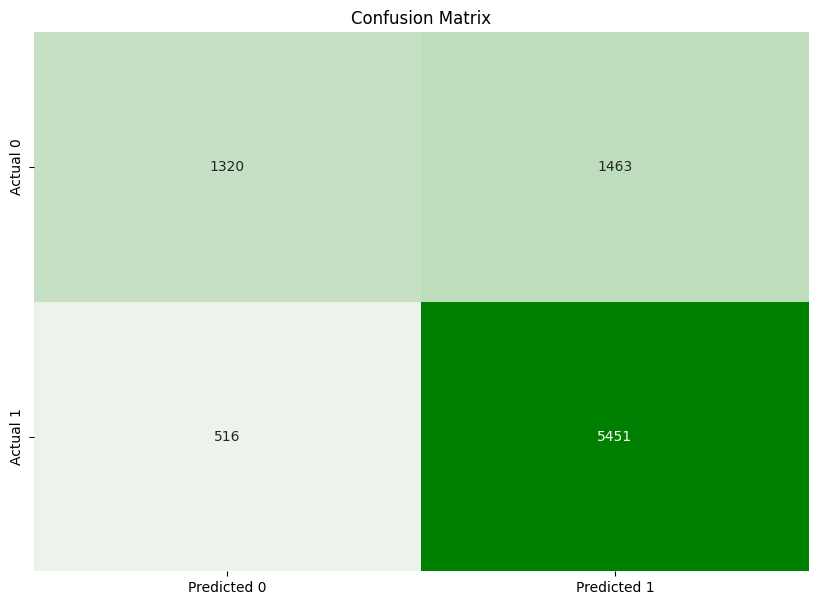

In [10]:
# Calculating metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Printing metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
# Create a custom color map
cmap = sns.light_palette("green", as_cmap=True)

# Plot the confusion matrix using seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.title('Confusion Matrix')
plt.show()

****

# Comparing mitigated to original

In [13]:
from fairlearn.metrics import MetricFrame

In [14]:
# Reading in the predictions from the original model
orignal_pred = pd.read_csv('rf_v1_test_predictions.csv')
y_pred_original = orignal_pred['predictions']

In [15]:
# Writing a function that will take any feature and metric and return charts and tables of the difference between original and mitigated

# First Manually defining positives and negatives
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Define False Positive Rate
def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)

# Define False Negative Rate
def false_negative_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

# Define Selection Rate
def selection_rate(y_true, y_pred):
    return sum(y_pred) / len(y_pred)

# Define Count (this is simply the length of y_pred)
def count(y_true, y_pred):
    return len(y_pred)

def compare_models(y_test, y_pred, y_pred_original, sensitive_features, metric, metric_name):
    # Define custom metrics if needed
    
    # Metrics dictionary
    metrics = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
        "F1 score": f1_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        "count": count,
    }

    # Create MetricFrame for both predictions
    mf_original = MetricFrame(metrics=metrics[metric], y_true=y_test, y_pred=y_pred_original, sensitive_features=sensitive_features)
    mf_new = MetricFrame(metrics=metrics[metric], y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)

    # Calculate the difference
    diff = mf_new.by_group - mf_original.by_group

    # Plotting the difference
    diff.plot(kind='bar', title=f"Difference in {metric_name} by {sensitive_features.name}")
    plt.ylabel(f"Delta {metric_name}")
    plt.show()

    return diff

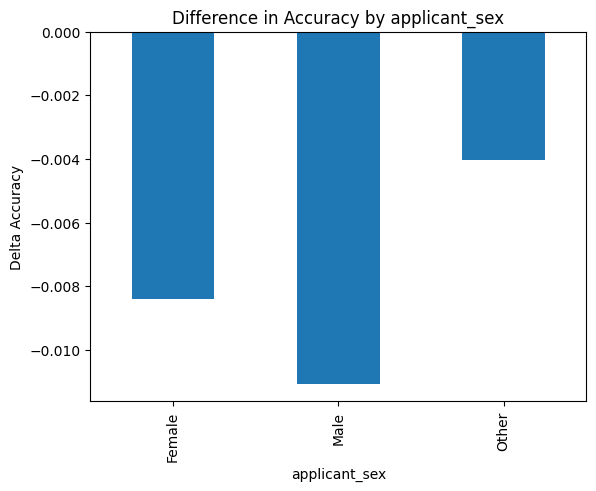

applicant_sex
Female   -0.008403
Male     -0.011070
Other    -0.004021
Name: accuracy_score, dtype: float64

In [16]:
# Testing the function. Note that it also returns a table for exact numbers. 
compare_models(y_test, y_pred, y_pred_original, sensitive_features_test['applicant_sex'], 'accuracy', 'Accuracy')

Analyzing Accuracy with respect to applicant_sex


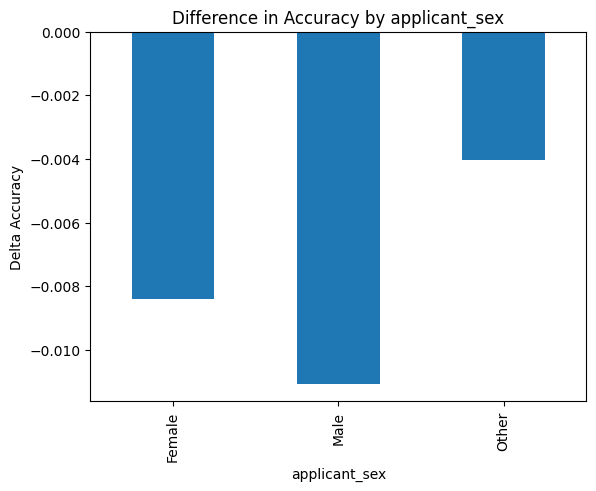

Analyzing Precision with respect to applicant_sex


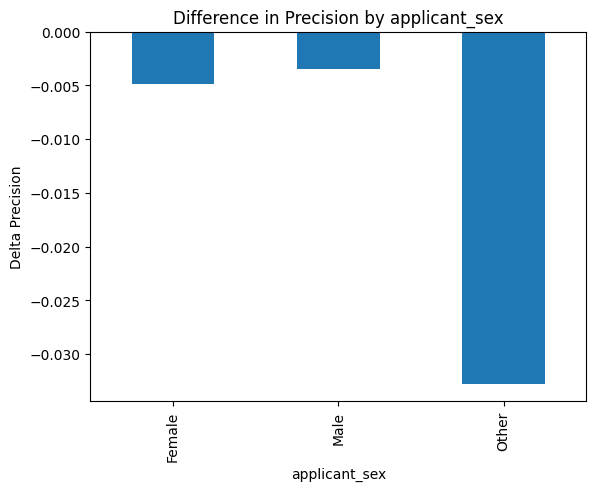

Analyzing Recall with respect to applicant_sex


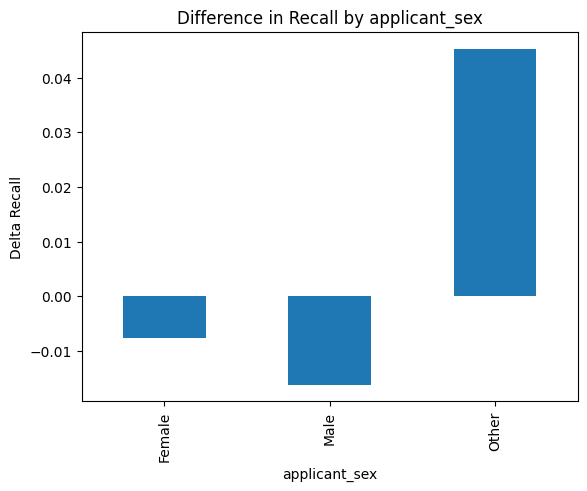

Analyzing F1 Score with respect to applicant_sex


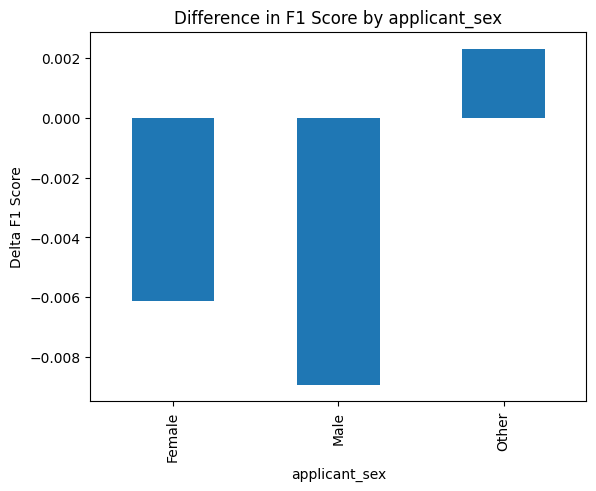

Analyzing False Positive Rate with respect to applicant_sex


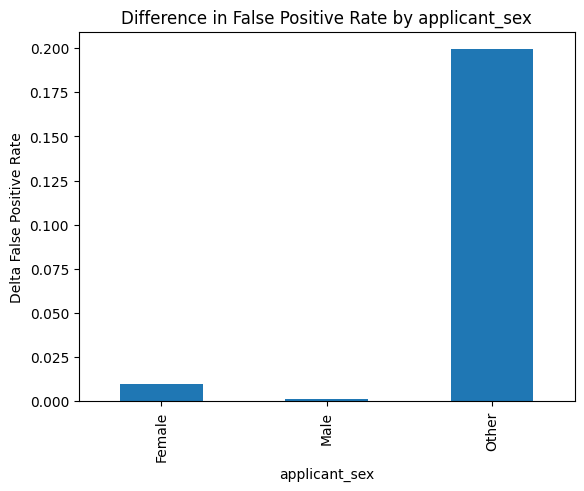

Analyzing False Negative Rate with respect to applicant_sex


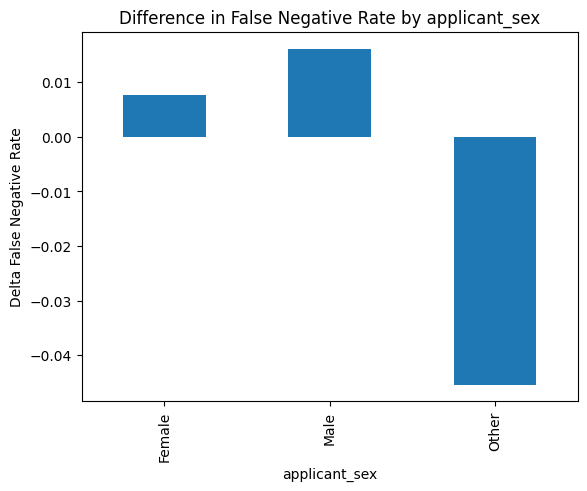

Analyzing Selection Rate with respect to applicant_sex


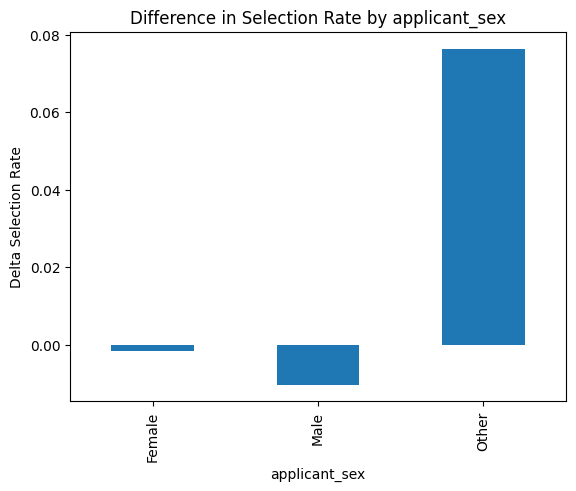

Analyzing Accuracy with respect to applicant_age_above_62


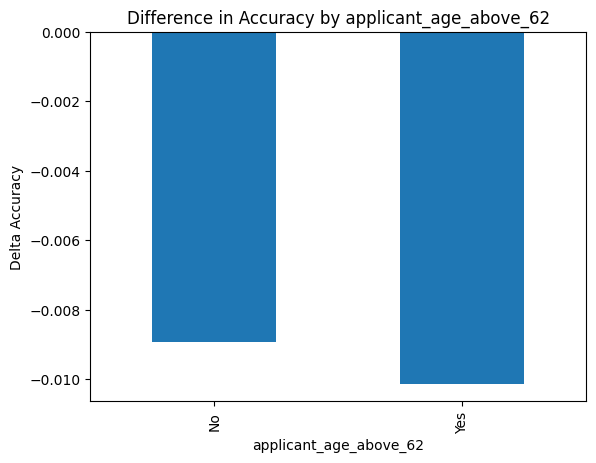

Analyzing Precision with respect to applicant_age_above_62


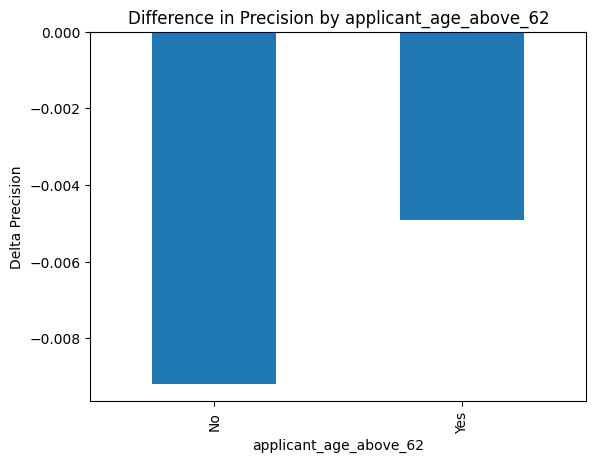

Analyzing Recall with respect to applicant_age_above_62


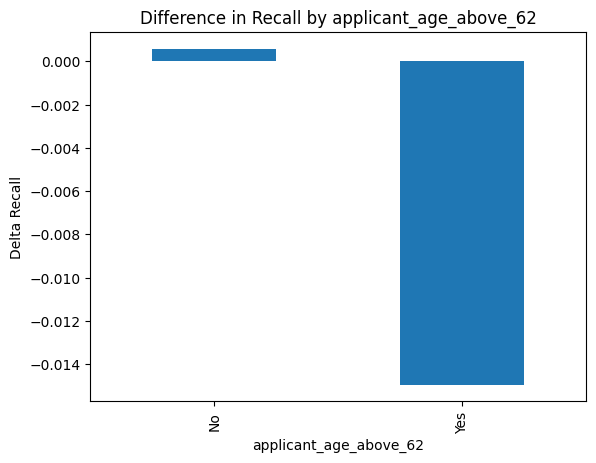

Analyzing F1 Score with respect to applicant_age_above_62


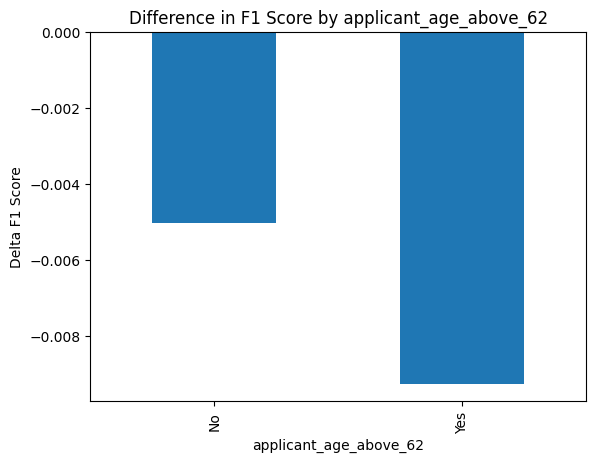

Analyzing False Positive Rate with respect to applicant_age_above_62


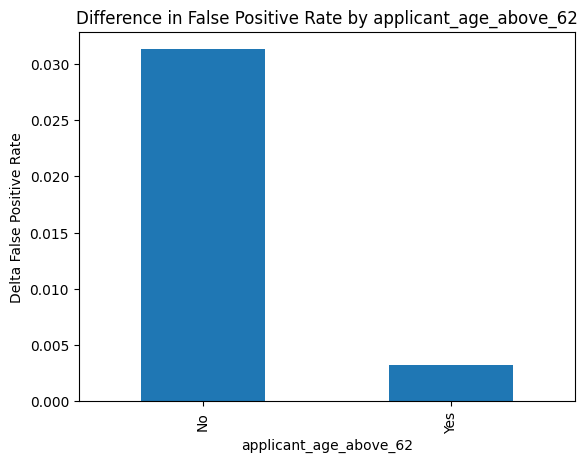

Analyzing False Negative Rate with respect to applicant_age_above_62


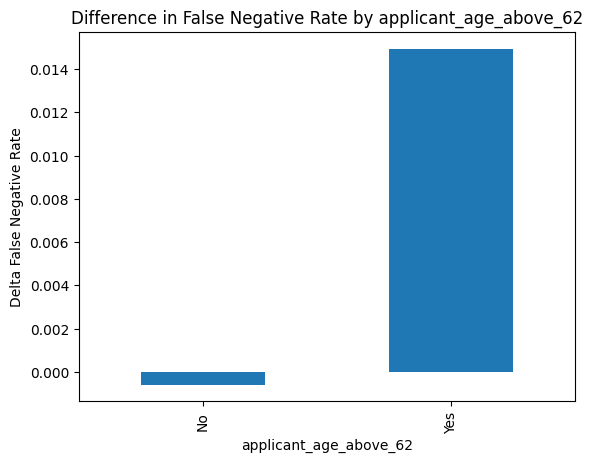

Analyzing Selection Rate with respect to applicant_age_above_62


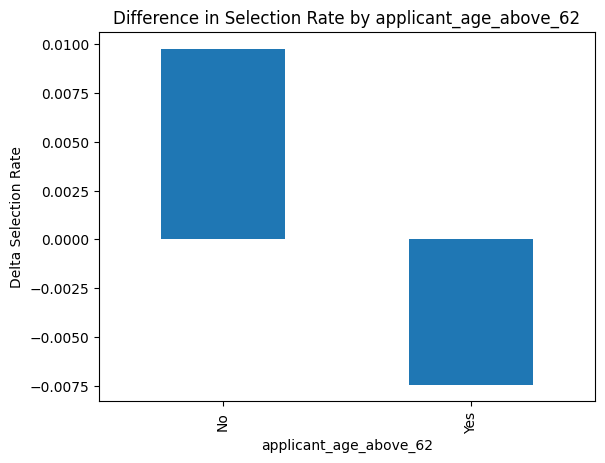

Analyzing Accuracy with respect to derived_race


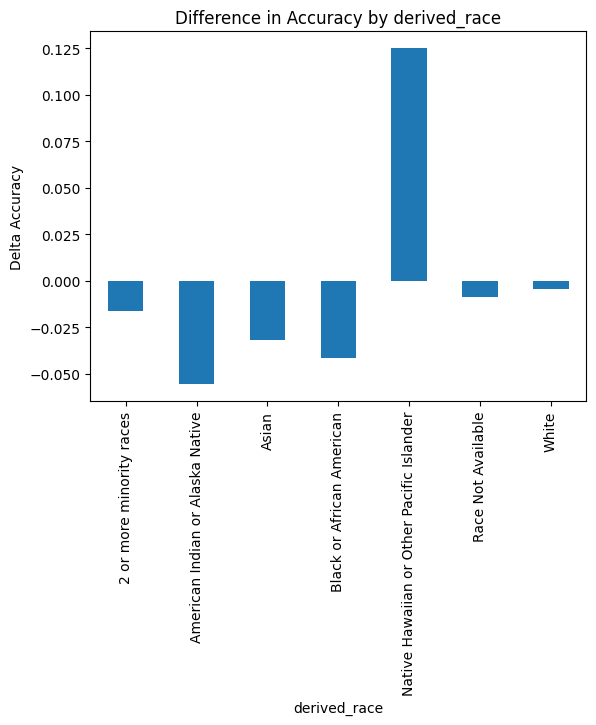

Analyzing Precision with respect to derived_race


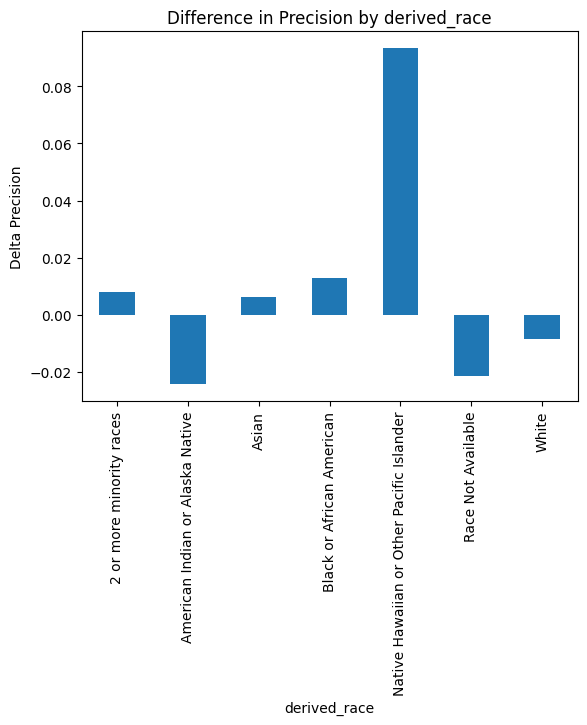

Analyzing Recall with respect to derived_race


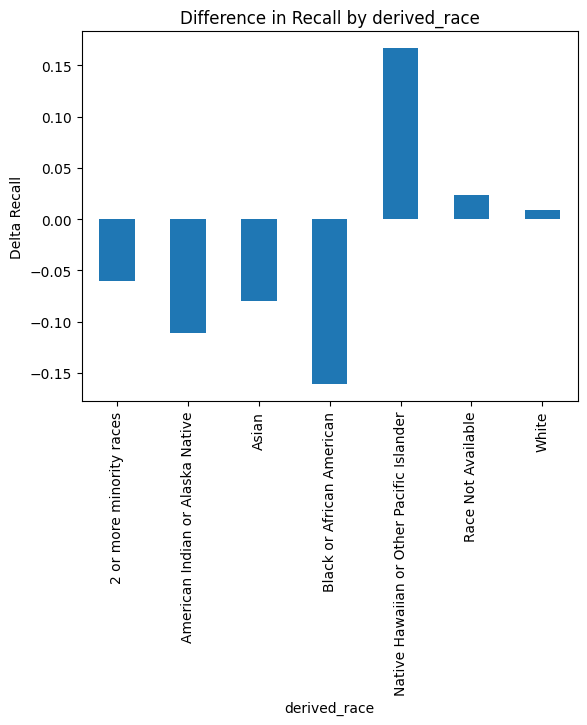

Analyzing F1 Score with respect to derived_race


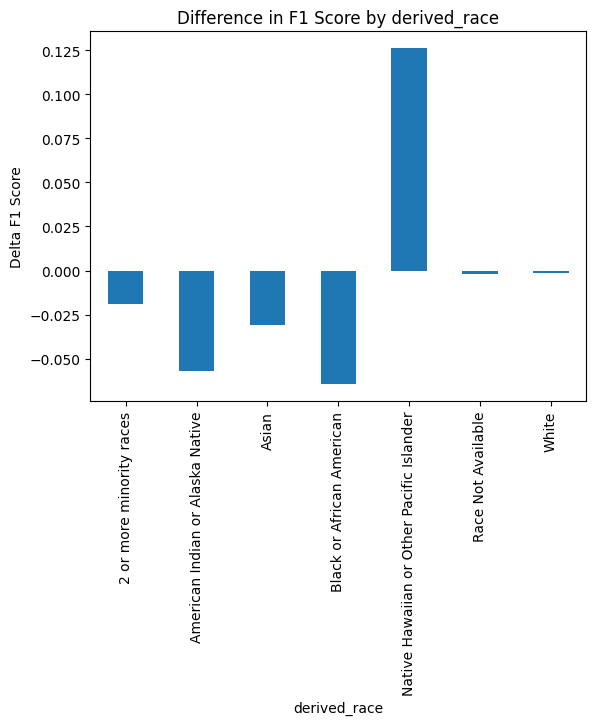

Analyzing False Positive Rate with respect to derived_race


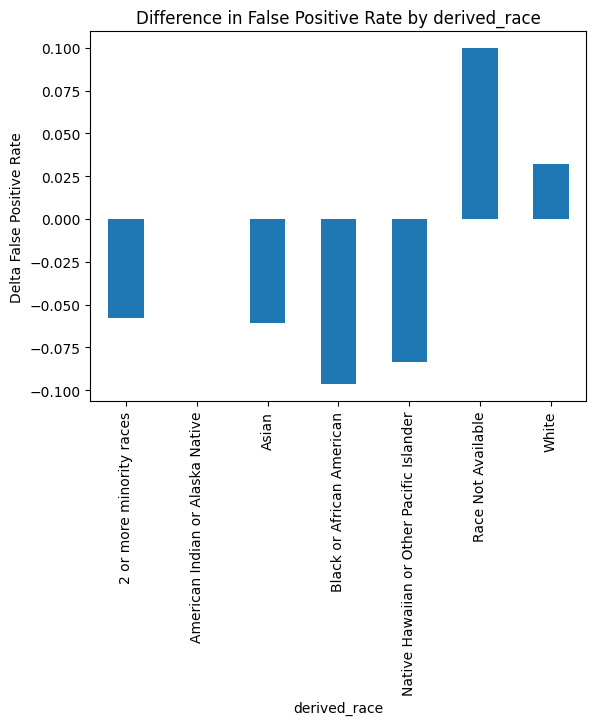

Analyzing False Negative Rate with respect to derived_race


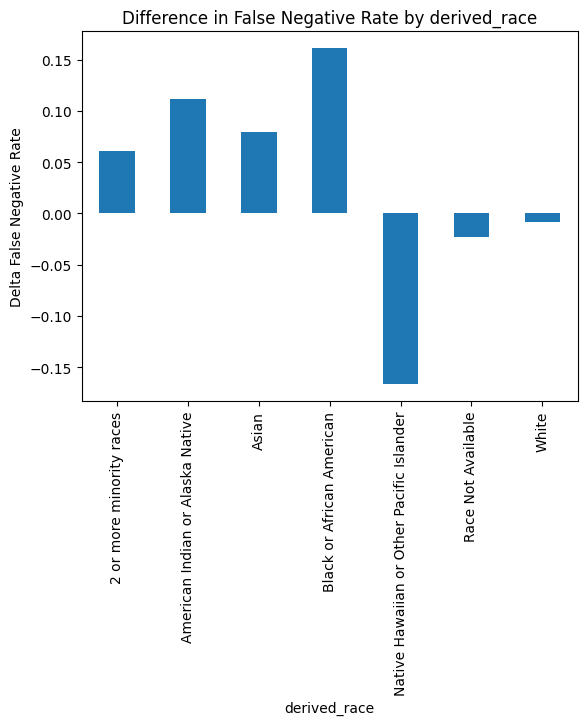

Analyzing Selection Rate with respect to derived_race


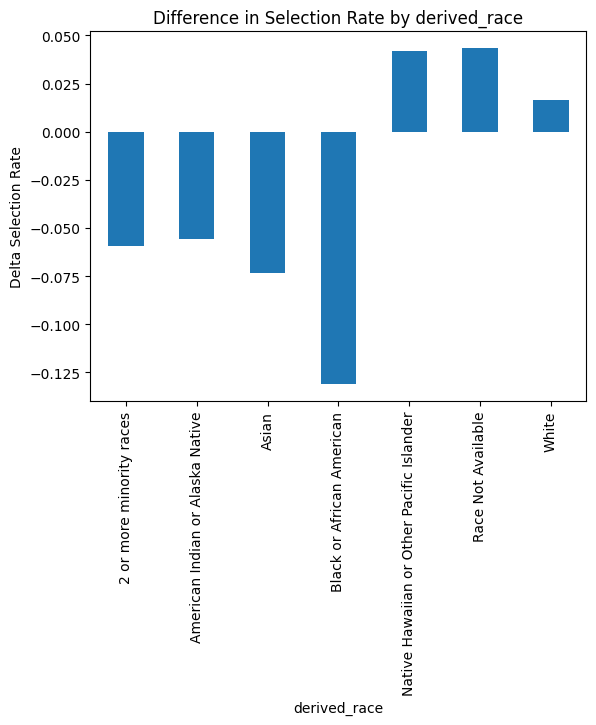

In [17]:
# List of metrics to compare
metrics_list = ['accuracy', 'precision', 'recall', 'F1 score', 'false positive rate', 'false negative rate', 'selection rate']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'Selection Rate']

# Looping through all features and metrics
for feature_name in sensitive_features_test.columns:
    for metric, metric_name in zip(metrics_list, metric_names):
        print(f"Analyzing {metric_name} with respect to {feature_name}")
        diff_df = compare_models(y_test, y_pred, y_pred_original, sensitive_features_test[feature_name], metric, metric_name)

        # Optional: Save or process diff_df here
        # e.g., diff_df.to_csv(f'{feature_name}_{metric}.csv')

### Now looking at percentage change in difference

In [18]:
def compare_models(y_test, y_pred, y_pred_original, sensitive_features, metric, metric_name):
    # Metrics dictionary
    metrics = {
        "accuracy": accuracy_score,
        "precision": precision_score,
        "recall": recall_score,
        "F1 score": f1_score,
        "false positive rate": false_positive_rate,
        "false negative rate": false_negative_rate,
        "selection rate": selection_rate,
        "count": count,
    }

    # Create MetricFrame for both predictions
    mf_original = MetricFrame(metrics=metrics[metric], y_true=y_test, y_pred=y_pred_original, sensitive_features=sensitive_features)
    mf_new = MetricFrame(metrics=metrics[metric], y_true=y_test, y_pred=y_pred, sensitive_features=sensitive_features)

    # Calculate the percentage change
    diff = ((mf_new.by_group - mf_original.by_group) / mf_original.by_group) * 100

    # Handling division by zero or NaN values if any
    diff = diff.replace([np.inf, -np.inf], np.nan).fillna(0)

    # Plotting the percentage change
    diff.plot(kind='bar', title=f"Percentage Change in {metric_name} by {sensitive_features.name}")
    plt.ylabel(f"% Change in {metric_name}")
    plt.show()

    return diff


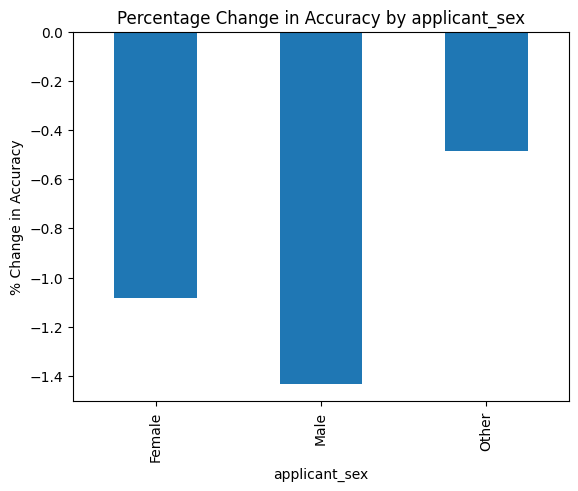

applicant_sex
Female   -1.084011
Male     -1.431981
Other    -0.485830
Name: accuracy_score, dtype: float64

In [19]:
# Testing the function. Note that it also returns a table for exact numbers. 
compare_models(y_test, y_pred, y_pred_original, sensitive_features_test['applicant_sex'], 'accuracy', 'Accuracy')

Analyzing Accuracy with respect to applicant_sex


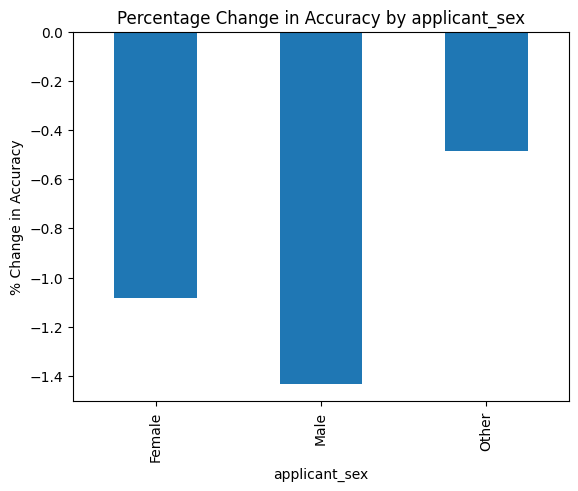

Analyzing Precision with respect to applicant_sex


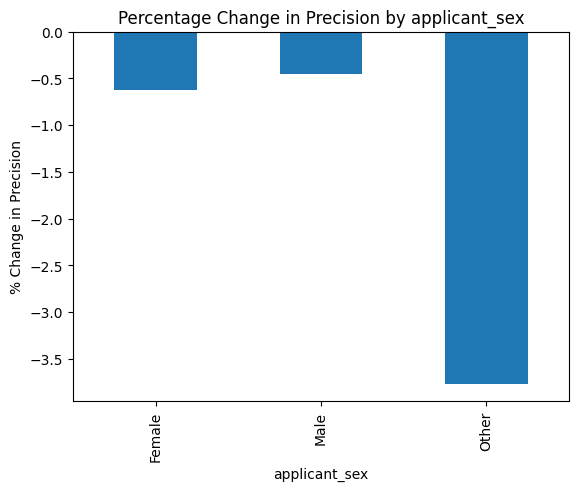

Analyzing Recall with respect to applicant_sex


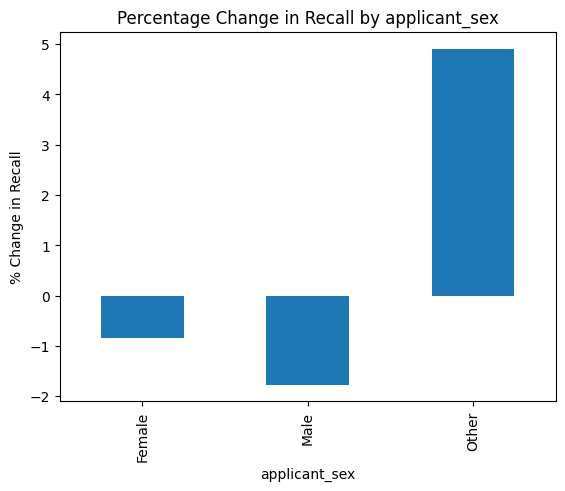

Analyzing F1 Score with respect to applicant_sex


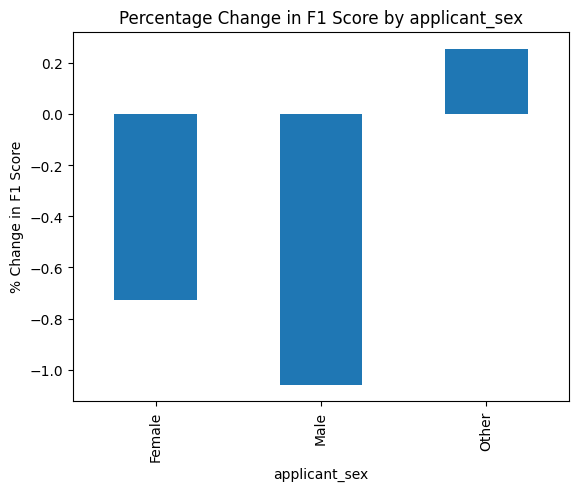

Analyzing False Positive Rate with respect to applicant_sex


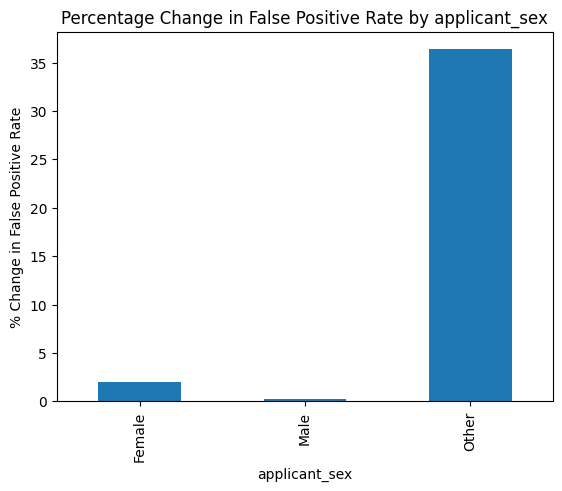

Analyzing False Negative Rate with respect to applicant_sex


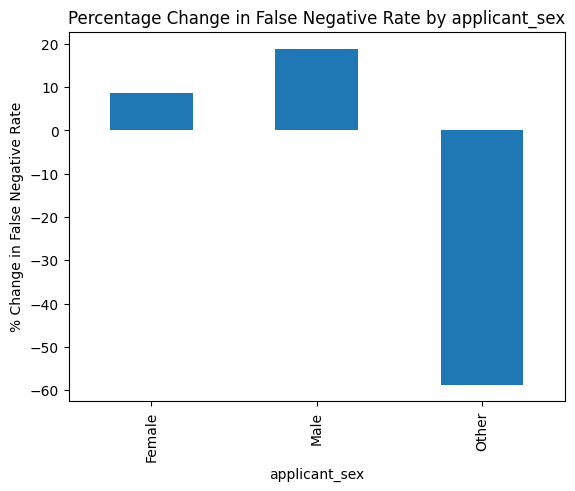

Analyzing Selection Rate with respect to applicant_sex


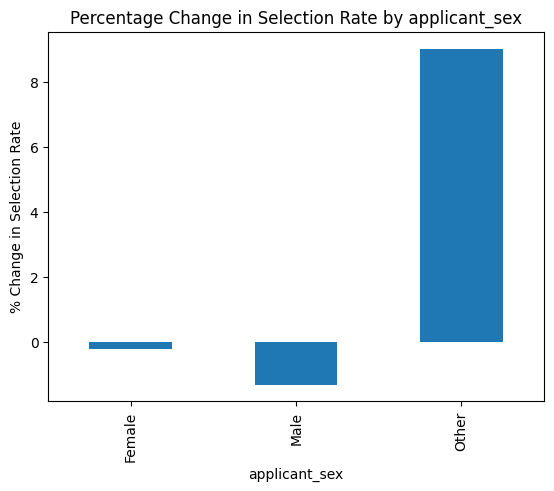

Analyzing Accuracy with respect to applicant_age_above_62


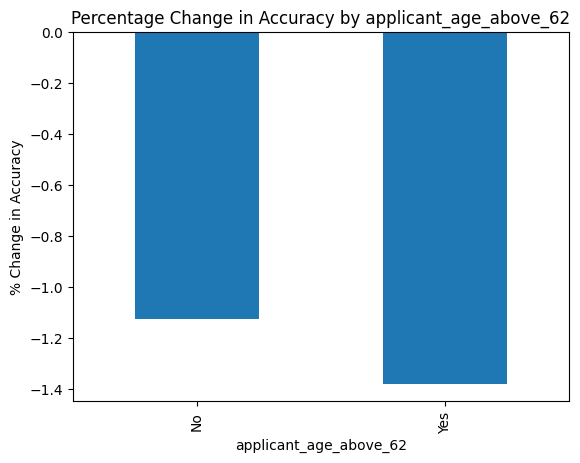

Analyzing Precision with respect to applicant_age_above_62


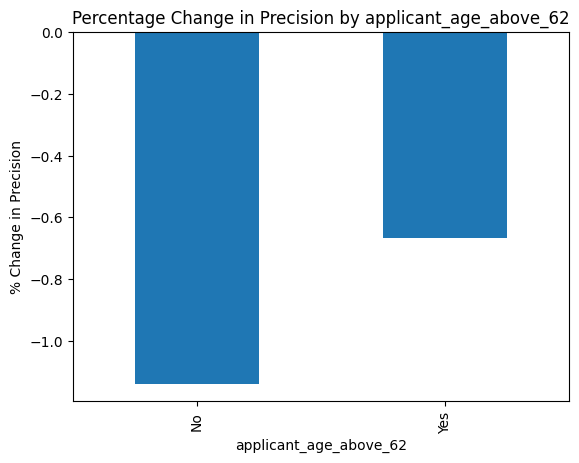

Analyzing Recall with respect to applicant_age_above_62


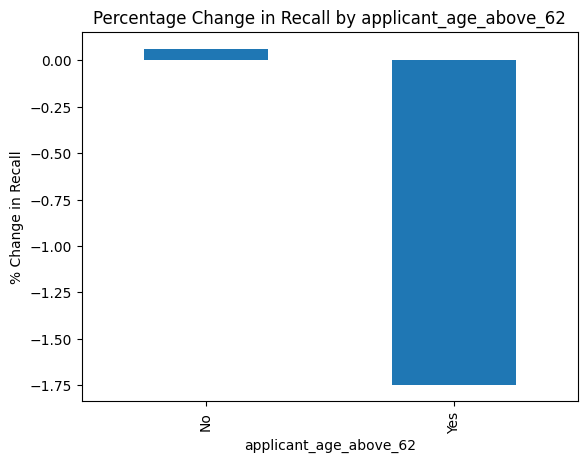

Analyzing F1 Score with respect to applicant_age_above_62


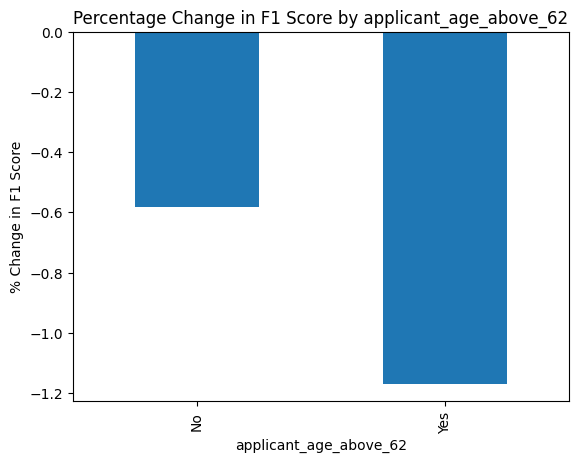

Analyzing False Positive Rate with respect to applicant_age_above_62


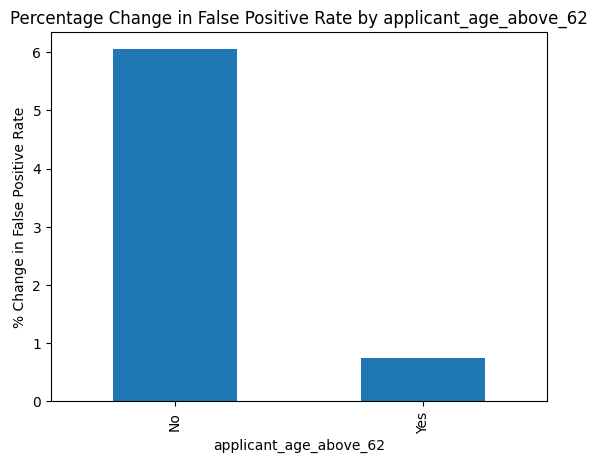

Analyzing False Negative Rate with respect to applicant_age_above_62


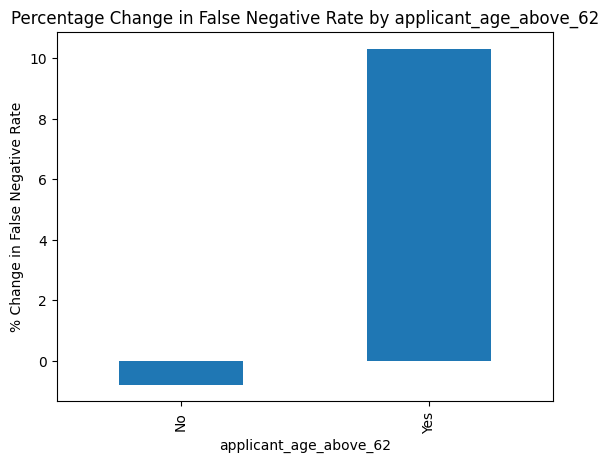

Analyzing Selection Rate with respect to applicant_age_above_62


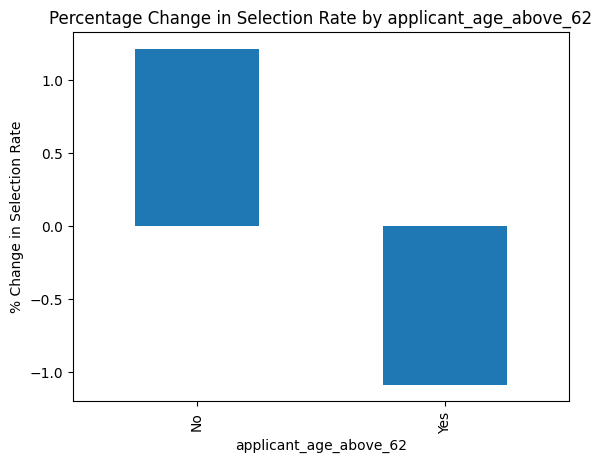

Analyzing Accuracy with respect to derived_race


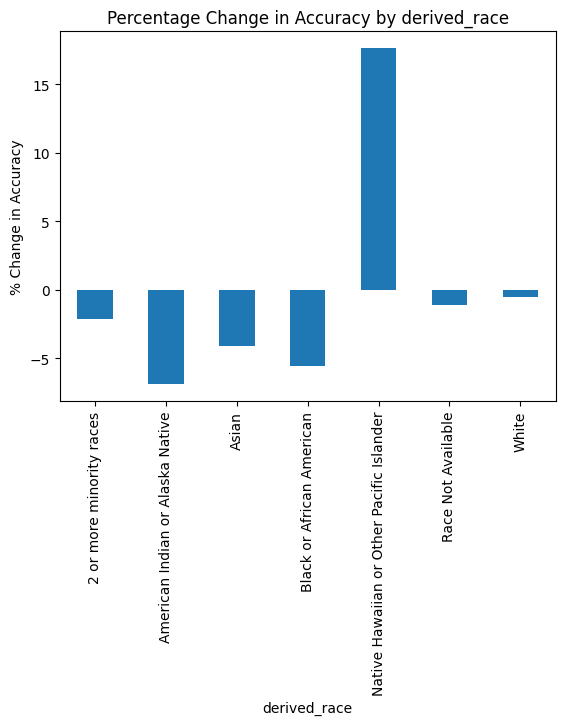

Analyzing Precision with respect to derived_race


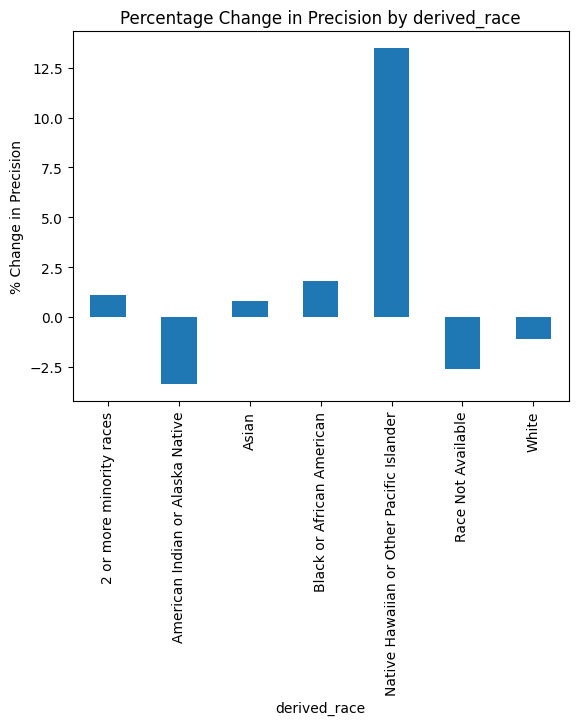

Analyzing Recall with respect to derived_race


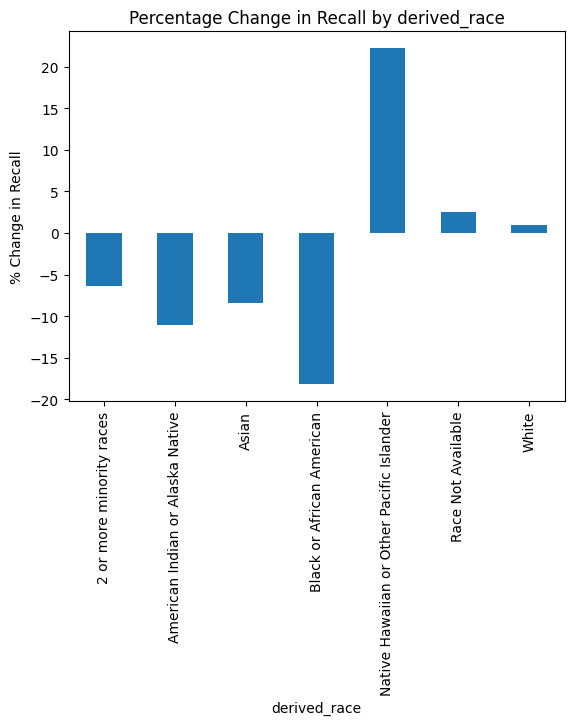

Analyzing F1 Score with respect to derived_race


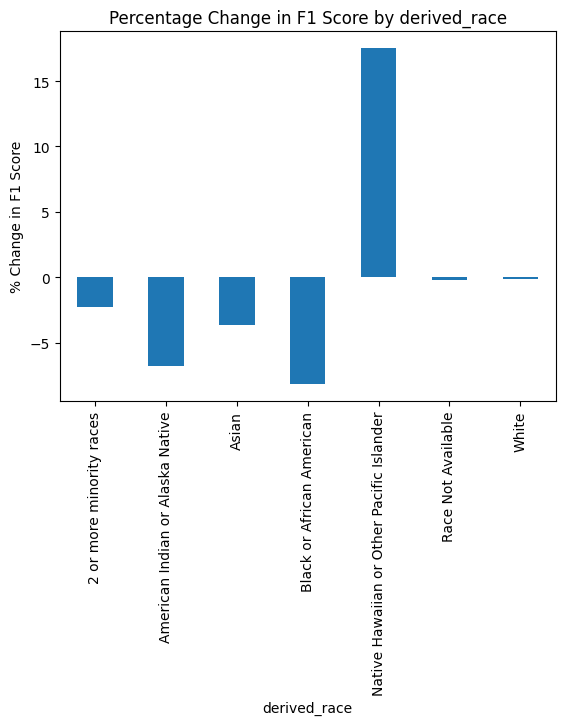

Analyzing False Positive Rate with respect to derived_race


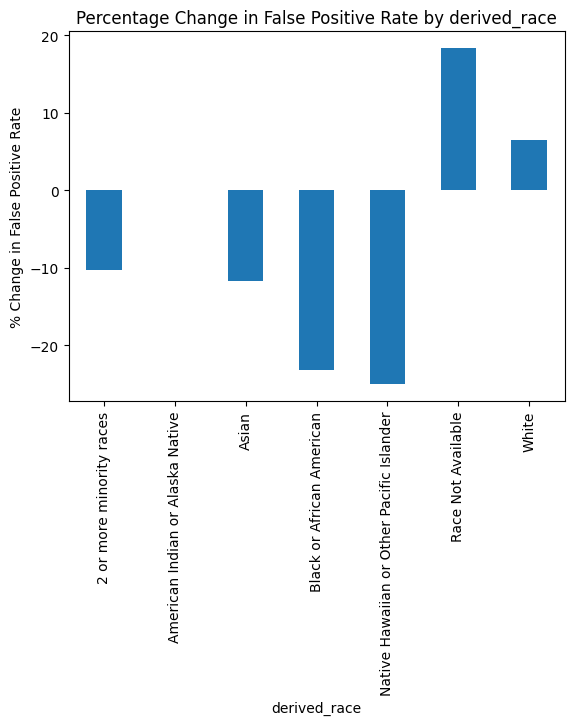

Analyzing False Negative Rate with respect to derived_race


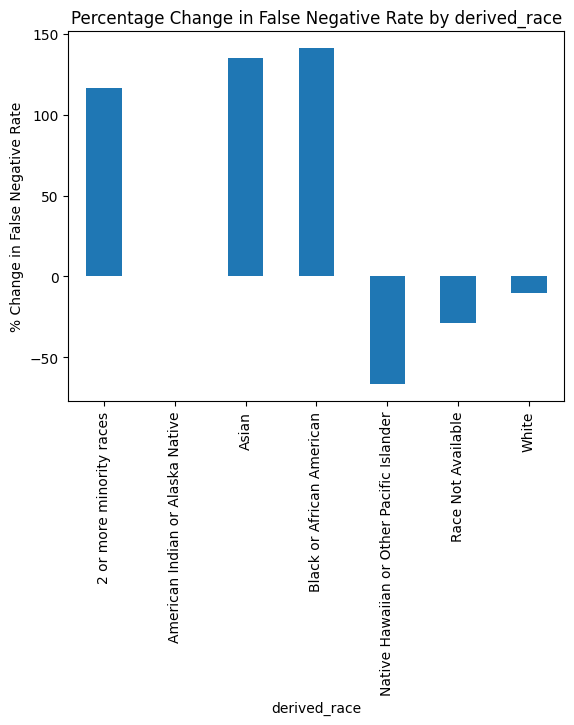

Analyzing Selection Rate with respect to derived_race


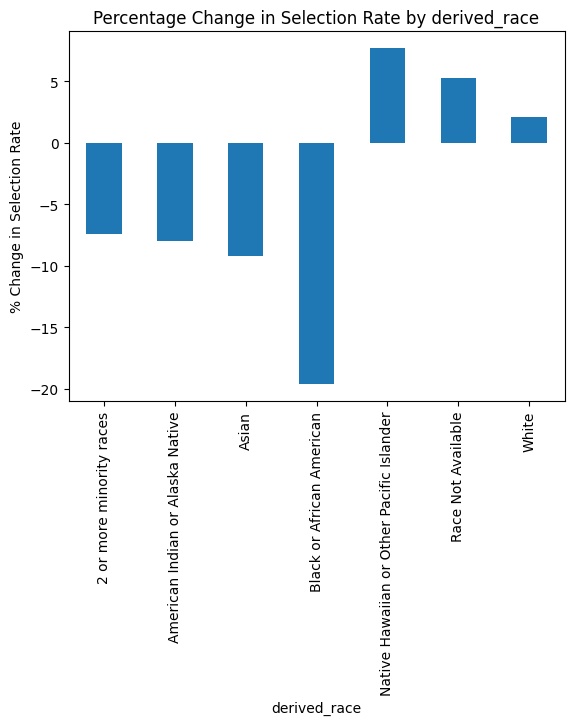

In [20]:
# List of metrics to compare
metrics_list = ['accuracy', 'precision', 'recall', 'F1 score', 'false positive rate', 'false negative rate', 'selection rate']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'False Positive Rate', 'False Negative Rate', 'Selection Rate']

# Looping through all features and metricse
for feature_name in sensitive_features_test.columns:
    for metric, metric_name in zip(metrics_list, metric_names):
        print(f"Analyzing {metric_name} with respect to {feature_name}")
        diff_df = compare_models(y_test, y_pred, y_pred_original, sensitive_features_test[feature_name], metric, metric_name)

        # Optional: Save or process diff_df here
        # e.g., diff_df.to_csv(f'{feature_name}_{metric}.csv')